In [42]:
import pandas as pd
import numpy as np
# vizualizasiya uchun
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import recall_score

In [43]:
df = pd.read_csv('https://raw.githubusercontent.com/HumayDS/Big-data-analysis/main/Churn_Modelling.csv')

In [44]:
#lazımsız sütunları sil
df = df.drop(['Unnamed: 0' , 'RowNumber' , 'CustomerId','Surname'] , axis = 1)
##Kategorik sütunu ən çox təkrarlanan dəyərlə (modla) doldur
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Geography'] = df['Geography'].fillna(df['Geography'].mode()[0])

In [45]:
#One- hot encoding, Dummy vars
#Kodu yalniz 1 defe run et
categorical_cols = df.select_dtypes(include='object').columns
df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True, dtype=int)
df = df.drop(columns=categorical_cols)
df = pd.concat([df, df_dummies], axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import pandas as pd

# 🎯 X xüsusiyyətlərini (X) və hədəf dəyişəni (y) müəyyən edirik
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/Test bölünməsi (stratify=y → sinif balansını qoruyur)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train-də orijinal sinif bölgüsü:", y_train.value_counts())

# 2️⃣ XGBoost modelinin qurulması və öyrədilməsi
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # Ağacların sayı (çox olduqda daha yaxşı öyrənir, amma overfit riski var)
    learning_rate=0.1,      # Addım ölçüsü (kiçik olarsa daha stabil, amma yavaş öyrənir)
    max_depth=4,            # Ağacların maksimal dərinliyi (dərinlik artdıqca model daha mürəkkəbləşir)
    subsample=0.8,          # Sətirlərin təsadüfi seçilmə faizi (overfiti azaltmaq üçün)
    colsample_bytree=0.8,   # Sütunların təsadüfi seçilmə faizi (overfiti azaltmaq üçün)
    reg_alpha=0.5,          # L1 reguliyasiya —overfiti azaldır (deyishkenlere ceza verir -- Bezi deyishkenleri sile biler)
    reg_lambda=2,           # L2 reguliyasiya — overfiti azaldır (deyishkenlere ceza verir)
    scale_pos_weight=4,     # Sinif balanssızlığı üçün çəkilər (məs: 80/20 → 4)
    random_state=42,        # Təkrarlanabilirlik üçün
)

xgb_model.fit(X_train, y_train)

# 3️⃣ Proqnozlar
pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)

# 🎯 Dəqiqlik
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"🔹 Train dəqiqlik: {acc_train:.4f}")
print(f"🔹 Test dəqiqlik:  {acc_test:.4f}\n")

# 4️⃣ Fərdi Confusion Matrix funksiyası
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cm_df = pd.DataFrame([[tp, fp],
                          [fn, tn]],
                         index=["Predicted 1", "Predicted 0"],
                         columns=["Actual 1", "Actual 0"])

    print("Confusion Matrix (Yuxarıda predicted, solda actual):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")

    return cm_df

# === Train nəticələri ===
print("=== Train nəticələri ===")
print(classification_report(y_train, pred_train))
confusion_matrix_custom(y_train, pred_train)

# === Test nəticələri ===
print("=== Test nəticələri ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)


Train-də orijinal sinif bölgüsü: Exited
0    5574
1    1426
Name: count, dtype: int64
🔹 Train dəqiqlik: 0.8617
🔹 Test dəqiqlik:  0.8143

=== Train nəticələri ===
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      5574
           1       0.61      0.86      0.72      1426

    accuracy                           0.86      7000
   macro avg       0.79      0.86      0.81      7000
weighted avg       0.89      0.86      0.87      7000

Confusion Matrix (Yuxarıda predicted, solda actual):
              Actual 1  Actual 0
Predicted 1      1226       768
Predicted 0       200      4806

TP: 1226, TN: 4806, FP: 768, FN: 200

=== Test nəticələri ===
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2389
           1       0.53      0.75      0.62       611

    accuracy                           0.81      3000
   macro avg       0.73      0.79      0.75      3000
weighted avg       0.85   

,Actual 1,Actual 0
Predicted 1,459,405
Predicted 0,152,1984


###SMOTE - Synthetic Minority Oversampling Technique
SMOTE / Oversampling:

If recall is still critical, it is possible to artificially increase the minority class.

Combining scale_pos_weight with SMOTE is often very effective.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pandas as pd
from collections import Counter

# 🎯 X xüsusiyyətləri (X) və hədəf dəyişəni (y) müəyyən edirik
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/test bölünməsi
# stratify=y → həm train, həm də test bölməsində sinif nisbətini qoruyur
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2️⃣ SMOTE ilə az olan sinfi artırırıq (class balancing)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Original class distribution:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_res))

# 3️⃣ scale_pos_weight hesablayırıq
# neg = mənfi sinifin sayı, pos = müsbət sinifin sayı
neg, pos = Counter(y_res)[0], Counter(y_res)[1]
scale_pos_weight = neg / pos
print(f"\nscale_pos_weight = {scale_pos_weight:.2f}\n")

# 4️⃣ XGBoost modelinin yaradılması və öyrədilməsi
# scale_pos_weight → sinif balanssızlığı üçün müsbət sinfə cəza çəkisi
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # ağacların sayı
    learning_rate=0.1,      # öyrənmə tempi
    max_depth=4,            # ağacların maksimal dərinliyi
    subsample=0.8,          # nümunələrin 80%-i ilə öyrənmə (overfitting azalır)
    colsample_bytree=0.8,   # sütunların 80%-i istifadə edilir
    reg_alpha=0.5,          # L1 regularization (overfitting-i azaldır)
    reg_lambda=2,           # L2 regularization
    #scale_pos_weight=4,     # balanssız siniflər üçün çəkilər
    random_state=42,
)

xgb_model.fit(X_res, y_res)

# 5️⃣ Təxminlər (predictions)
pred_train = xgb_model.predict(X_res)
pred_test = xgb_model.predict(X_test)

# Dəqiqlik (accuracy)
acc_train = accuracy_score(y_res, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"🔹 Train accuracy: {acc_train:.4f}")
print(f"🔹 Test accuracy:  {acc_test:.4f}\n")

# 6️⃣ Confusion matrix: Yuxarıda proqnozlar, solda real dəyərlər
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Matrisin bizə uyğun formatda göstərilməsi
    cm_df = pd.DataFrame([[tp, fp],
                          [fn, tn]],
                         index=["Predicted 1", "Predicted 0"],
                         columns=["Actual 1", "Actual 0"])

    print("Confusion Matrix (Predicted on top, Actual on left):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")

    return cm_df

# Train üçün
print("=== For Train set ===")
print(classification_report(y_res, pred_train))
confusion_matrix_custom(y_res, pred_train)

# Test üçün
print("=== For Test set ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)

Original class distribution: Counter({0: 5574, 1: 1426})
Class distribution after SMOTE: Counter({0: 5574, 1: 5574})

scale_pos_weight = 1.00

🔹 Train accuracy: 0.8701
🔹 Test accuracy:  0.8123

=== For Train set ===
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5574
           1       0.88      0.86      0.87      5574

    accuracy                           0.87     11148
   macro avg       0.87      0.87      0.87     11148
weighted avg       0.87      0.87      0.87     11148

Confusion Matrix (Predicted on top, Actual on left):
              Actual 1  Actual 0
Predicted 1      4810       684
Predicted 0       764      4890

TP: 4810, TN: 4890, FP: 684, FN: 764

=== For Test set ===
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2389
           1       0.53      0.68      0.60       611

    accuracy                           0.81      3000
   macro avg       0.72      

,Actual 1,Actual 0
Predicted 1,418,370
Predicted 0,193,2019


              Feature  Importance
6      IsActiveMember    0.295445
10        Gender_Male    0.160411
4       NumOfProducts    0.128184
1                 Age    0.127933
9     Geography_Spain    0.096330
5           HasCrCard    0.066395
8   Geography_Germany    0.036935
3             Balance    0.031808
2              Tenure    0.020106
7     EstimatedSalary    0.019302
0         CreditScore    0.017152


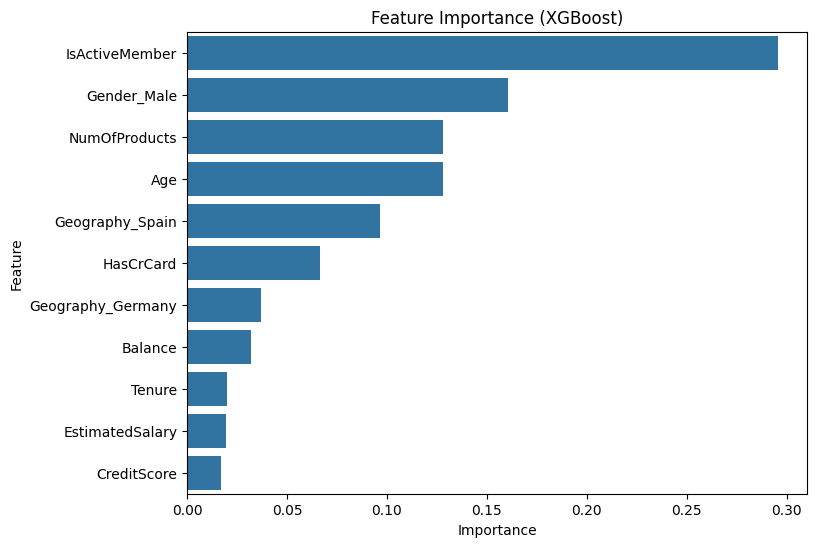

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance dəyərlərini götür
importance = xgb_model.feature_importances_

# DataFrame-ə salaq
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by="Importance", ascending=False)

print(feat_imp)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance (XGBoost)")
plt.show()


IsActiveMember (0.295) — Ən güclü göstərici
Bu dəyişən modelin qərarlarının 29.5%-ni izah edir.

Gender_Male (0.160) — Cins fərqi mühüm rol oynayır
Modelin qərarlarının 16%-i müştərinin kişi olub-olmamasından asılıdır.

ve s.

# Cross Validation

Cross-Validation — bu elə bir texnikadır ki, verilənlər dəsti bir neçə hissəyə bölünür və model tək bir train/test bölünməsi ilə yox, müxtəlif hissələrin kombinasiyalarında dəfələrlə yoxlanılır.
Bu, modelin daha obyektiv və daha dəqiq qiymətləndirilməsinə kömək edir.

Tək bir 70/30 və ya 80/20 bölünmə təsadüfi ola bilər və etibarlı sayılmır.
Cross-Validation modeli bir neçə müxtəlif bölünmə üzərində yoxlayır və bu təsadüfilikdən yaranan qeyri-dəqiqliyi azaldır.

Məlumat K hissəyə bölünür (məsələn, K=5).
Hər dəfə 1 hissə test üçün, qalan hissələr isə train üçün istifadə olunur.
Model K dəfə öyrədilir və nəticələr orta hesabla birləşdirilir.

Bu, overfitting-i azaldır, modeli daha dəqiq qiymətləndirir və ən yaxşı modeli seçməyə kömək edir.

##Cross-Validation overfitting-i necə azaldır?

Model tək bir train/test bölünməsinə əsaslanmır.
70/30 bölünməsində model təsadüfən asan test hissəsinə düşə və yüksək nəticə göstərə bilər.

Cross-validation isə:

məlumatı bir neçə hissəyə bölür,

modeli müxtəlif test fold-lar üzərində qiymətləndirir,

nəticələri orta hesabla birləşdirir.

➡️ Model konkret bir bölünməni “əzbərləyə” bilmir.
➡️ Bu da overfitting-i azaldır.

###Model həqiqətən yaxşı generalizasiya edirsə → bütün fold-lar üzrə oxşar nəticə göstərir.
###Əgər overfitting edibsə → validasiya nəticələri yuxarı-aşağı dəyişir (stabil olmur).

In [49]:
from IPython.display import Image

# Display an image from the web
url = "https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/featured.png"
display(Image(url=url))


In [50]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import pandas as pd
from collections import Counter

# 🎯 X xüsusiyyətləri (X) və hədəf dəyişəni (y) müəyyən edirik
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/test bölünməsi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Original class distribution in TRAIN:", Counter(y_train))

# 2️⃣ scale_pos_weight hesablayırıq (yalnız train üzərindən)
neg, pos = Counter(y_train)[0], Counter(y_train)[1]
scale_pos_weight = neg / pos
print(f"scale_pos_weight (neg/pos) = {scale_pos_weight:.2f}\n")

# 3️⃣ XGBoost modelinin parametrləri
xgb_params = dict(
    n_estimators=200,       # ağacların sayı
    learning_rate=0.1,      # öyrənmə tempi
    max_depth=4,            # ağacların maksimal dərinliyi
    subsample=0.8,          # nümunələrin 80%-i ilə öyrənmə (overfitting azalır)
    colsample_bytree=0.8,   # sütunların 80%-i istifadə edilir
    reg_alpha=0.5,          # L1 regularization (overfitting-i azaldır)
    reg_lambda=2,           # L2 regularization
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # balanssız siniflər üçün çəkilər
)

# 4️⃣ 5-fold Cross-Validation (yalnız orijinal train üzərində, SMOTE YOXDUR)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_cv_model = xgb.XGBClassifier(**xgb_params)

cv_scores = cross_val_score(
    xgb_cv_model,
    X_train, y_train,
    cv=cv,
    scoring='recall'   # müsbət sinif (1) üçün recall
)

print("✅ 5-fold CV RECALL scores:", cv_scores)
print(f"✅ Mean CV recall: {cv_scores.mean():.4f}")
print(f"✅ Std of CV recall: {cv_scores.std():.4f}\n")

# 5️⃣ Son modeli bütün TRAIN üzərində öyrədirik (SMOTE-siz)
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

# 6️⃣ Test üçün təxminlər (predictions)
pred_test = xgb_model.predict(X_test)

acc_test = accuracy_score(y_test, pred_test)
print(f"🔹 Test accuracy:  {acc_test:.4f}\n")

# 7️⃣ Confusion matrix: Yuxarıda proqnozlar, solda real dəyərlər
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Matrisin bizə uyğun formatda göstərilməsi
    cm_df = pd.DataFrame(
        [[tp, fp],
         [fn, tn]],
        index=["Predicted 1", "Predicted 0"],
        columns=["Actual 1", "Actual 0"]
    )

    print("Confusion Matrix (Predicted on top, Actual on left):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")

    return cm_df

# 🔍 Yalnız TEST üçün hesabat
print("=== For Test set ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)


Original class distribution in TRAIN: Counter({0: 5574, 1: 1426})
scale_pos_weight (neg/pos) = 3.91

✅ 5-fold CV RECALL scores: [0.6877193  0.69473684 0.73333333 0.67719298 0.70629371]
✅ Mean CV recall: 0.6999
✅ Std of CV recall: 0.0192

🔹 Test accuracy:  0.8123

=== For Test set ===
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2389
           1       0.53      0.74      0.62       611

    accuracy                           0.81      3000
   macro avg       0.73      0.78      0.75      3000
weighted avg       0.84      0.81      0.82      3000

Confusion Matrix (Predicted on top, Actual on left):
              Actual 1  Actual 0
Predicted 1       451       403
Predicted 0       160      1986

TP: 451, TN: 1986, FP: 403, FN: 160



,Actual 1,Actual 0
Predicted 1,451,403
Predicted 0,160,1986


Decision Tree, Random Forest, XGBoost → Ağac əsaslı (tree based ) modellər

SVM, KNN, GMM → Məsafə əsaslı (distance based ) modellər

SVM nədir? (Support Vector Machines)
Kiçik və orta ölçülü datasetlər üçün effektlidir.

Support Vector Machines (SVM) — klassifikasiya və reqressiya üçün istifadə olunan nəzarət olunan (supervised) maşın öyrənməsi modelidir.
SVM-in məqsədi məlumatları siniflərə ayıran ən yaxşı sərhədi (hiperplanı) tapmaqdır.
“Ən yaxşı hiperplan” — margin-i maksimum edən sərhəddir, yəni hiperplanla hər iki sinifə aid ən yaxın nöqtələr arasındakı məsafə maksimum olur.

Bu sərhədə ən yaxın olan nöqtələr support vectors (dəstək vektorları) adlanır. Onlar hiperplanın dəqiq yerini “dəstəkləyir” və müəyyən edir.

Təsəvvür edin ki, iki sinif məlumat var (qırmızı və mavi nöqtələr). Onları ayıran çox xətt çəkmək olar, amma SVM ən optimal olanı seçir.

Optimal hiperplan = margin-i maksimum edən hiperplan

SVM-də support vectors — qərar sərhədinə (hiperplana) ən yaxın olan nöqtələrdir.

Margin — hiperplan ilə hər iki tərəfdəki ən yaxın nöqtələrin arasındakı məsafədir.

In [51]:
from IPython.display import Image

# Display an image from the web
url = "https://data-flair.training/blogs/wp-content/uploads/sites/2/2019/07/introduction-to-SVM.png"
display(Image(url=url))


SVM-in əsas hiperparametrləri

Kernel (Yadra funksiyası)

C (C cəza parametri)

Gamma (γ parametri)

Kernel — xətti ayırmaq mümkün olmadıqda məlumatları ayırmağa imkan verən funksiyadır.

kernel = 'linear'
Əgər data xətti şəkildə ayrılabilirsə, SVM sadə düz xətt (hiperplan) çəkir.

kernel = 'rbf'
Əgər data xətti şəkildə ayrıla bilmirsə, kernel məlumatı daha yüksək ölçülü fəzada ayrılmasını mümkün edir.Radial Basis Function (RBF) Kernel: Bu kernel, verilənləri daha yüksək ölçülü məkanlara daşıyaraq siniflər arasındakı qeyri-xətti əlaqələri tapmağa imkan verir. RBF kernel çox yaygın və effektivdir.

Kernel — məlumat xətti şəkildə ayrıla bilməyəndə SVM-ə onları ayırmağa kömək edən funksiyadır.

kernel = 'linear'
Əgər data xətti olaraq ayrılabilirsə, SVM sadə düz xətt (hiperplan) çəkir.

kernel = 'rbf' Radial Basis Function

Əgər data xətti olaraq ayrıla bilmirsə, kernel məlumatı daha yüksək ölçülü fəzada transformasiya edir və bu fəzada ayırmaq mümkün olur.
Kernel seçimi: Modelin performansı üçün ən vacib qərarlardan biridir. Verilənlər xətti ayırıla bilmirsə, RBF və Polynomial kernel-lərdən istifadə tövsiyə olunur.

In [52]:


from IPython.display import Image

# Display an image from the web
url = "https://media.geeksforgeeks.org/wp-content/uploads/20250513094345928254/svm.webp?utm_source=chatgpt.com"
display(Image(url=url))


Linear kernel-i istifadə et:

Data  xətti şəkildə ayrılırsa

Daha sadə və daha sürətli model istəyirsənsə

RBF kernel-i istifadə et:

Data kompleks və qeyri-xətti nümunələrə malikdirsə

Daha yüksək model performansı istəyirsənsə

#2. C parameter

Bu parametr modelin cərimə dərəcəsini təyin edir. Kiçik C dəyərləri daha geniş marjin, lakin daha çox səhv qəbul edərkən; böyük C dəyərləri daha az səhv, lakin dar marjinə səbəb olur

C = SVM-in səhv təsnif edilmiş nöqtələrə verdiyi cəzanın miqdarıdır.

C kiçik olanda → SVM daha “rahatdır”, yumşaq yanaşır, səhvlərə tolerantdır

C böyük olanda → SVM daha sərtdir, hər nöqtəni düzgün təsnif etməyə çalışır

Böyük C → overfitting riskini artırır
Kiçik C → underfitting edə bilər, amma daha yaxşı ümumiləşdirir

ML mühəndislərinin ən çox istifadə etdiyi diapazon:

➤ C ∈ {0.01, 0.1, 1, 10, 100}

C böyük seçildikdə (1 → 10 → 100)
Model bütün nöqtələri düzgün təsnif etməyə daha çox çalışır.

In [53]:


from IPython.display import Image

# Display an image from the web
url = "https://cdn.hashnode.com/res/hashnode/image/upload/v1735885699184/222d7252-7ece-4e31-97f5-577bb8577797.png?utm_source=chatgpt.com"
display(Image(url=url))


#3. Gamma

Gamma: Xüsusilə RBF kernel üçün vacibdir. Gamma yüksək olduqda model daha lokal qərarlar verir (overfitting riski artır), aşağı olduqda isə ümumiləşdirmə gücü artır.

Gamma (γ) — RBF kernel-in “enliyi” və ya “təsir radiusu” kimi işləyir.
Texniki olaraq, gamma bir data nöqtəsinin nə qədər böyük ərazidə təsir göstərdiyini ölçür.

Kiçik γ → hər bir nöqtə geniş ərazidə təsir göstərir

Böyük γ → hər bir nöqtə yalnız özünə çox yaxın olan nöqtələrə təsir edir (overfitting riski artır)

Gamma artdıqca təsir radiusu daralır, model daha lokallaşır və nəticədə overfitting baş verir.

Əgər gamma çox böyükdürsə, hər bir nöqtə yalnız yaxınındakı nöqtələri təsirləndirir, model hər detalı əzbərləyir, bu da overfitting-ə səbəb olur.

In [54]:

from IPython.display import Image

# Display an image from the web
url = "https://scikit-learn.org/stable/_images/sphx_glr_plot_rbf_parameters_001.png"
display(Image(url=url))


SVM üçün scaling çox vacibdir
(tree-based modellər üçün isə vacib deyil)

SVM, KNN, Logistic Regression kimi məsafə əsaslı modellərdə scaling mütləqdir — xüsusiyyətlərin ölçü fərqləri nəticəyə ciddi təsir edir.

Decision Tree, Random Forest, XGBoost kimi ağac əsaslı modellərdə isə scaling-ə ehtiyac yoxdur — çünki bu modellər yalnız düyünləri bölmək üçün xüsusiyyətlərin nisbi sırasına baxırlar, ölçü vahidinə yox.

Scaling = bütün xüsusiyyətləri eyni ədədi aralığa çevirmək deməkdir.

Məsələn:

Age → 26

Salary → 1800

Əgər scaling etməsən:

Salary böyük rəqəmlərlə ifadə olunur → model maaşa daha çox diqqət edir

Age kiçik rəqəmdir → model yaşı çox az nəzərə alır

Scaling etdikdə isə bütün xüsusiyyətlər oxşar miqyasda olur və heç bir xüsusiyyət ədalətsiz şəkildə dominant olmur.

In [55]:
from IPython.display import Image

# Display an image from the web
url = "https://miro.medium.com/v2/resize:fit:640/format:webp/1*Bx8sWhleKvBdSWECm6eeFg.png"
display(Image(url=url))

Data o zaman scaling (miqyaslandırma) olunmalıdır ki, modeldə məsafə mühüm rol oynayır.Məsafə əsaslı (distance based) modellər rəqəmlərin ölçüsünə həssasdır. Feature-lar fərqli ölçüdə olarsa model səhv işləyəcək.(KNN (K-Nearest Neighbors)

K-means clustering

Hierarchical clustering

SVM (xüsusilə RBF kernel, polynomial kernel)

PCA (çünki variance ölçülür)

Neural Networks / MLP / Deep Learning)

Bu modellər decision tree strukturuna əsaslanır, rəqəmlərin ölçüsü heç bir rol oynamır.

✔ Scaling TƏLƏB ETMİR:

Decision Tree

Random Forest

XGBoost

LightGBM

CatBoost

Ağaclar sadəcə feature-ları bölür (threshold) → rəqəmin 10 və ya 10,000 olması vacib deyil.

###Normalization vs Standardization (fərq)

Normalization (Min-Max Scaling) -Dəyəri 0 və 1 aralığına sıxır.  Feature-lərin hər biri eyni aralığa düşür: 0–1
Orijinal paylanmanın formasını dəyişdirir, sıxır.

Standardization (Z-score Scaling)

Dəyəri orta = 0, std = 1 olacaq şəkildə çevrilir.

Outlier varsa → Standardization (Z-score) daha yaxşı işləyir.

Normalization (Min-Max) isə çox pis zədələnir.

In [56]:
from sklearn.preprocessing import StandardScaler

# Xüsusiyyətləri (X) və hədəf dəyişəni (y) ayır
X = df.drop(columns=['Exited'])
y = df['Exited']

# StandardScaler-i inicializasiya et
scaler = StandardScaler()

# Xüsusiyyətləri fit və transform et (standartlaşdır)
X_scaled = scaler.fit_transform(X)

# Standartlaşdırılmış xüsusiyyətləri yenidən DataFrame-ə çevir
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Standartlaşdırılmış xüsusiyyətləri hədəf dəyişəni ilə birləşdir
df_scaled = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)

print("Standartlaşdırılmış DataFrame-in ilk 5 sətri (df_scaled):")
print(df_scaled.head())

Standartlaşdırılmış DataFrame-in ilk 5 sətri (df_scaled):
   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.326221  0.293517 -1.041760 -1.225848      -0.911583   0.646092   
1    -0.440036  0.198164 -1.387538  0.117350      -0.911583  -1.547768   
2    -1.536794  0.293517  1.032908  1.333053       2.527057   0.646092   
3     0.501521  0.007457 -1.387538 -1.225848       0.807737  -1.547768   
4     2.063884  0.388871 -1.041760  0.785728      -0.911583   0.646092   

   IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0        0.970243         0.021886          -0.578736        -0.573809   
1        0.970243         0.216534          -0.578736         1.742740   
2       -1.030670         0.240687          -0.578736        -0.573809   
3       -1.030670        -0.108918          -0.578736        -0.573809   
4        0.970243        -0.365276          -0.578736         1.742740   

   Gender_Male  Exited  
0    -1.096209       1  
1 

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import pandas as pd

# 🎯 X xüsusiyyətlərini (X) və hədəf dəyişəni (y) təyin et
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/test bölünməsi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train üçün orijinal sinif paylanması:")
print(y_train.value_counts(), "\n")

# 2️⃣ Miqyaslandırma (SVM üçün ÇOX VACİBDİR)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3️⃣ SVM modelini yarat və təlim et
svm_model = SVC(
    kernel='rbf',              # qeyri-xətti məlumatlar üçün RBF kernel
    C=1.0,                    # C - cəza parametri
    gamma='scale',            # gamma - təsir radiusu
    class_weight='balanced',  # dataset qeyri-bərabərdirsə aktiv edin (balans üçün)
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)

# 4️⃣ Proqnozlar
pred_train = svm_model.predict(X_train_scaled)
pred_test = svm_model.predict(X_test_scaled)

# Dəqiqlik (Accuracy)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"🔹 Train dəqiqliyi: {acc_train:.4f}")
print(f"🔹 Test dəqiqliyi:  {acc_test:.4f}\n")

# 5️⃣ Xüsusi qarışıqlıq matrisi funksiyası
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cm_df = pd.DataFrame([[tp, fp],
                          [fn, tn]],
                         index=["Predicted 1", "Predicted 0"],
                         columns=["Actual 1", "Actual 0"])

    print("Qarışıqlıq Matrisi (Yuxarıda proqnoz, solda reallıq):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")
    return cm_df

# === Train set üçün ===
print("=== Train set üçün ===")
print(classification_report(y_train, pred_train))
confusion_matrix_custom(y_train, pred_train)

# === Test set üçün ===
print("=== Test set üçün ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)


Train üçün orijinal sinif paylanması:
Exited
0    5574
1    1426
Name: count, dtype: int64 

🔹 Train dəqiqliyi: 0.8131
🔹 Test dəqiqliyi:  0.7917

=== Train set üçün ===
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      5574
           1       0.53      0.80      0.64      1426

    accuracy                           0.81      7000
   macro avg       0.73      0.81      0.75      7000
weighted avg       0.86      0.81      0.83      7000

Qarışıqlıq Matrisi (Yuxarıda proqnoz, solda reallıq):
              Actual 1  Actual 0
Predicted 1      1139      1021
Predicted 0       287      4553

TP: 1139, TN: 4553, FP: 1021, FN: 287

=== Test set üçün ===
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2389
           1       0.49      0.76      0.60       611

    accuracy                           0.79      3000
   macro avg       0.71      0.78      0.73      3000
weighted avg       

,Actual 1,Actual 0
Predicted 1,464,478
Predicted 0,147,1911


#KNN - (K nearest neighbor )

KNN (K-Nearest Neighbors) – yeni bir məlumat nöqtəsi üçün proqnoz verərkən ona ən yaxın K qonşuya baxan modeldir.

❌ Böyük datasetlərdə yavaşdır, çünki hər bir yeni nöqtə üçün bütün nöqtələrlə məsafə hesablamalı olur.

###1 Yeni bir məlumat nöqtəsi daxil olur.
Məsələn: yeni bir müştəri.

####2 KNN həmin nöqtəyə ən yaxın K qonşunu tapır.
Bunun üçün məsafədən istifadə edir (adətən Evklid məsafəsi).

#### 3 Qonşuların label-lərinə baxılır.
Məsələn: K = 5 olduqda:

3 qonşu “1” sinifindədir

2 qonşu “0” sinifindədir

#### 4 Əksəriyyət səsi (Majority vote).
Çünki “1” daha çoxdur → proqnoz = 1.

K nədir?

K = modelin neçə qonşuya baxmalı olduğunu göstərən hiperparametrdir.

✔ K kiçik olanda → model çox həssas olur, overfitting edə bilər
✔ K böyük olanda → model çox hamar olur, underfitting baş verə bilər

Ən çox istifadə olunan K dəyərləri:

K = 3, 5, 7, 9

Bu dəyərlər həm sabit nəticə verir, həm də çox böyük olmadığı üçün overfitting/underfitting riskini balanslaşdırır.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# 🎯 X xüsusiyyətlərini (X) və hədəf dəyişəni (y) müəyyən et
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/test bölünməsi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train üçün orijinal sinif paylanması:")
print(y_train.value_counts(), "\n")

# 2️⃣ Miqyaslandırma (KNN üçün ÇOX VACİBDİR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3️⃣ KNN modelini yarat və öyrət
knn_model = KNeighborsClassifier(
    n_neighbors=5,      # K = 5 (bu dəyəri dəyişib tənzimləyə bilərsiniz)
)

knn_model.fit(X_train_scaled, y_train)

# 4️⃣ Proqnozlar
pred_train = knn_model.predict(X_train_scaled)
pred_test = knn_model.predict(X_test_scaled)

# Dəqiqlik
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"🔹 Train dəqiqliyi (KNN): {acc_train:.4f}")
print(f"🔹 Test dəqiqliyi (KNN):  {acc_test:.4f}\n")

# 5️⃣ Xüsusi qarışıqlıq matrisi funksiyası
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cm_df = pd.DataFrame([[tp, fp],
                          [fn, tn]],
                         index=["Predicted 1", "Predicted 0"],
                         columns=["Actual 1", "Actual 0"])

    print("Qarışıqlıq Matrisi (Yuxarıda proqnoz, Solda reallıq):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")
    return cm_df

# === Train set üçün ===
print("=== Train set (KNN) üçün ===")
print(classification_report(y_train, pred_train))
confusion_matrix_custom(y_train, pred_train)

# === Test set üçün ===
print("=== Test set (KNN) üçün ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)


Train üçün orijinal sinif paylanması:
Exited
0    5574
1    1426
Name: count, dtype: int64 

🔹 Train dəqiqliyi (KNN): 0.8700
🔹 Test dəqiqliyi (KNN):  0.8213

=== Train set (KNN) üçün ===
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      5574
           1       0.80      0.48      0.60      1426

    accuracy                           0.87      7000
   macro avg       0.84      0.73      0.76      7000
weighted avg       0.86      0.87      0.86      7000

Qarışıqlıq Matrisi (Yuxarıda proqnoz, Solda reallıq):
              Actual 1  Actual 0
Predicted 1       687       171
Predicted 0       739      5403

TP: 687, TN: 5403, FP: 171, FN: 739

=== Test set (KNN) üçün ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2389
           1       0.60      0.37      0.46       611

    accuracy                           0.82      3000
   macro avg       0.73      0.65      0.67      30

,Actual 1,Actual 0
Predicted 1,225,150
Predicted 0,386,2239


KNN-in class imbalance problemi üçün alqoritm səviyyəsində (daxili) həlli yoxdur. Buna görə problemi SMOTE metodu ilə həll edəcəyik.

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd

# 🎯 X xüsusiyyətlərini (X) və hədəf dəyişəni (y) müəyyən et
X = df.drop(columns=['Exited'])
y = df['Exited']

# 1️⃣ Train/test bölünməsi (stratify = hər iki hissədə sinif nisbətini qorumaq üçün)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train üçün orijinal sinif paylanması:")
print(y_train.value_counts(), "\n")

# 2️⃣ İmbalance problemini yalnız TRAIN set üzərində həll edirik (SMOTE)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("SMOTE-dən sonra (Train):")
print(pd.Series(y_train_res).value_counts(), "\n")

# 3️⃣ Miqyaslandırma (KNN üçün ÇOX VACİBDİR)
scaler = StandardScaler()
scaler.fit(X_train_res)              # yalnız resampled train üzərində fit edilir
X_train_res_scaled = scaler.transform(X_train_res)
X_test_scaled      = scaler.transform(X_test)

# 4️⃣ KNN modelinin yaradılması və öyrədilməsi
knn_model = KNeighborsClassifier(
    n_neighbors=5,      # K = 5 (tənzimlənə bilər)
    weights='uniform',  # və ya 'distance'
    metric='minkowski',
    p=2                 # Evklid məsafəsi (p=2)
)

knn_model.fit(X_train_res_scaled, y_train_res)

# 5️⃣ Proqnozlar
# 🔹 Train üçün: qiymətləndirməni ORİJİNAL train set üzərində edirik (SMOTE yox)
X_train_scaled = scaler.transform(X_train)
pred_train = knn_model.predict(X_train_scaled)

# 🔹 Test üçün
pred_test = knn_model.predict(X_test_scaled)

# Dəqiqlik
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print(f"🔹 Train dəqiqliyi (KNN + SMOTE): {acc_train:.4f}")
print(f"🔹 Test dəqiqliyi  (KNN + SMOTE): {acc_test:.4f}\n")

# 6️⃣ Xüsusi qarışıqlıq matrisi funksiyası
def confusion_matrix_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    cm_df = pd.DataFrame([[tp, fp],
                          [fn, tn]],
                         index=["Predicted 1", "Predicted 0"],
                         columns=["Actual 1", "Actual 0"])

    print("Qarışıqlıq Matrisi (Yuxarıda proqnoz, Solda reallıq):\n", cm_df)
    print(f"\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n")
    return cm_df

# === Train set üçün ===
print("=== Train set (KNN + SMOTE) üçün ===")
print(classification_report(y_train, pred_train))
confusion_matrix_custom(y_train, pred_train)

# === Test set üçün ===
print("=== Test set (KNN + SMOTE) üçün ===")
print(classification_report(y_test, pred_test))
confusion_matrix_custom(y_test, pred_test)


Train üçün orijinal sinif paylanması:
Exited
0    5574
1    1426
Name: count, dtype: int64 

SMOTE-dən sonra (Train):
Exited
0    5574
1    5574
Name: count, dtype: int64 

🔹 Train dəqiqliyi (KNN + SMOTE): 0.8264
🔹 Test dəqiqliyi  (KNN + SMOTE): 0.7547

=== Train set (KNN + SMOTE) üçün ===
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      5574
           1       0.55      0.75      0.64      1426

    accuracy                           0.83      7000
   macro avg       0.74      0.80      0.76      7000
weighted avg       0.85      0.83      0.84      7000

Qarışıqlıq Matrisi (Yuxarıda proqnoz, Solda reallıq):
              Actual 1  Actual 0
Predicted 1      1074       863
Predicted 0       352      4711

TP: 1074, TN: 4711, FP: 863, FN: 352

=== Test set (KNN + SMOTE) üçün ===
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      2389
           1       0.43      0.65      0.52    

,Actual 1,Actual 0
Predicted 1,395,520
Predicted 0,216,1869


##PCA (Principal Component Analysis)

PCA (Principal Component Analysis) — çox ölçülü datanı sadələşdirən, amma informasiya itkisini minimum edən metoddur.
Sanki çox şəkilli, qarışıq məlumatı daha az ölçüyə sıxır, amma əsas mənanı saxlayır.PCA — datadakı ən çox dəyişkənliyin olduğu istiqamətləri tapır və datanı o istiqamətlərə proyeksiya edir.PCA — çox feature-li datanı daha az ölçüyə sıxıb, əsas informasiyanı saxlayan siqnal çıxarma metodudur.

Tutaq ki, datada 100 feature var (Yaş, gəlir, balans, kredit score və s.).Bu 100 feature-dan bəziləri təkrar məlumat daşıyır.100 feature-dan əslində 2–3 xətt (direction) əsas informasiyanı izah edir."
Bu yeni direction-lara Principal Component deyilir.

###PCA niyə vacibdir?
1. Feature sayını azaldır (dimensionality reduction)

100 dəyişən → 5 dəyişən
Amma informasiyanın 90%-i qalır.

✔️ 2. Modelləri sürətləndirir

KNN, Logistic Regression, SVM daha tez işləyir.

✔️ 3. Multicollinearity problemini həll edir (Independent(X) dəyişkənlərin yüksək korrelyasiyada olmasıdır.

Çox əlaqəli featurlər → PCA ilə aradan qalxır.

✔️ 4. Visualization üçün

3D olmayan datanı 2D qrafikdə göstərmək üçün ideal.

###PCA necə işləyir?

1️⃣ Features-i standartlaşdırır


2️⃣ Korrelyasiya matrisi qurur


3️⃣ En çox dəyişənlik haradadır → tapır


4️⃣ Yeni oxlar (PC1, PC2, PC3…) yaradır


5️⃣ Datanı bu oxlara proyeksiya edir

#PCR  (Principal Component Regression)

PCR — PCA + Linear Regression deməkdir.

Yəni PCA ilə ölçü azaldılır, sonra bu yeni komponentlərlə linear regression qurulur.

PCR — PCA ilə ən informativ istiqamətləri tapıb, həmin komponentlərlə regression edən metoddur.

PCR
1. Multicollinearity problemini
Çox əlaqəli feature-lər PCA ilə bir komponentə yığılır.


2. Overfittingi azaldır
lazımsız ölçülər  atılır → model daha stabil olur.

3. High-dimensional datada çox effektivdir

500 feature olsa belə 5–10 komponent kifayətdir.

### PCR Istifadəsi
Feature-lərin sayı çox böyükdür

Featurlər bir-birinə çox benzerdir (multicollinearity)